<a href="https://colab.research.google.com/github/Vasanthpathi549/Mini-Project/blob/master/Product_Recommendation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**1.Import Libraries**

In [0]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O
import os
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"
import math
import json
import time
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.model_selection import train_test_split
from sklearn.neighbors import NearestNeighbors
from sklearn.externals import joblib
import scipy.sparse
from scipy.sparse import csr_matrix
from scipy.sparse.linalg import svds
# import warnings; warnings.simplefilter('ignore')
# %matplotlib inline

**2.Load the dataset and add headers**

In [0]:
electronics_data=pd.read_csv("ratings_Electronics (1).csv",names=['userId', 'productId','Rating','timestamp'])

In [10]:
#Display the data
electronics_data.head()

,userId,productId,Rating,timestamp
0,AKM1MP6P0OYPR,0132793040,5.0,1365811200
1,A2CX7LUOHB2NDG,0321732944,5.0,1341100800
2,A2NWSAGRHCP8N5,0439886341,1.0,1367193600
3,A2WNBOD3WNDNKT,0439886341,3.0,1374451200
4,A1GI0U4ZRJA8WN,0439886341,1.0,1334707200


In [11]:
#shape of data
electronics_data.shape

(566756, 4)

In [0]:
#Taking subset of the dataset
electronics_data=electronics_data.iloc[:560000,0:]

In [13]:
#Check the datatypes
electronics_data.dtypes

userId        object
productId     object
Rating       float64
timestamp      int64
dtype: object

In [14]:
electronics_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 560000 entries, 0 to 559999
Data columns (total 4 columns):
 #   Column     Non-Null Count   Dtype  
---  ------     --------------   -----  
 0   userId     560000 non-null  object 
 1   productId  560000 non-null  object 
 2   Rating     560000 non-null  float64
 3   timestamp  560000 non-null  int64  
dtypes: float64(1), int64(1), object(2)
memory usage: 17.1+ MB


In [15]:
#Five point summary 
electronics_data.describe()['Rating'].T

count    560000.000000
mean          3.987593
std           1.394229
min           1.000000
25%           3.000000
50%           5.000000
75%           5.000000
max           5.000000
Name: Rating, dtype: float64

In [16]:
#Find the minimum and maximum ratings
print('Minimum rating is: %d' %(electronics_data.Rating.min()))
print('Maximum rating is: %d' %(electronics_data.Rating.max()))

Minimum rating is: 1
Maximum rating is: 5


The rating of the product range from 1 to 5

**Handling Missing Values**

In [17]:
#Check for missing values
print('Number of missing values across columns: \n',electronics_data.isnull().sum())

Number of missing values across columns: 
 userId       0
productId    0
Rating       0
timestamp    0
dtype: int64


**Ratings**

/usr/local/lib/python3.6/dist-packages/seaborn/categorical.py:3669: UserWarning: The `factorplot` function has been renamed to `catplot`. The original name will be removed in a future release. Please update your code. Note that the default `kind` in `factorplot` (`'point'`) has changed `'strip'` in `catplot`.
  warnings.warn(msg)


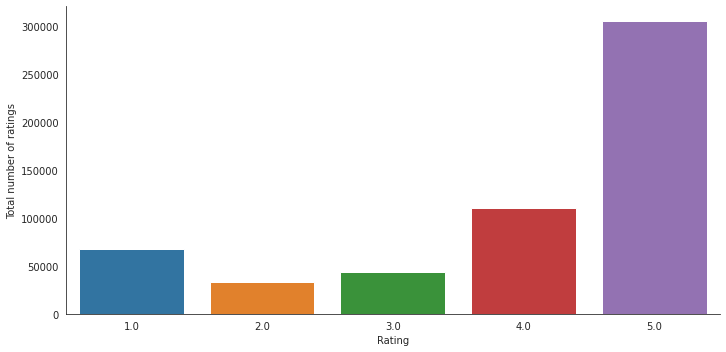

In [18]:
# Check the distribution of the rating
with sns.axes_style('white'):
    g = sns.factorplot("Rating", data=electronics_data, aspect=2.0,kind='count')
    g.set_ylabels("Total number of ratings")

Most of the people has given the rating of 5

**Unique users and products**

In [19]:
print("Total data ")
print("-"*50)
print("\nTotal no of ratings :",electronics_data.shape[0])
print("Total No of Users   :", len(np.unique(electronics_data.userId)))
print("Total No of products  :", len(np.unique(electronics_data.productId)))

Total data 
--------------------------------------------------

Total no of ratings : 560000
Total No of Users   : 448403
Total No of products  : 33789


**Dropping the timestamp column**

In [0]:
#Dropping the Timestamp column
electronics_data.drop(['timestamp'], axis=1,inplace=True)

**Analysing the rating**

In [21]:
#Analysis of rating given by the user 
no_of_rated_products_per_user = electronics_data.groupby(by='userId')['Rating'].count().sort_values(ascending=False)
no_of_rated_products_per_user.head()

userId
A5JLAU2ARJ0BO     327
A231WM2Z2JL0U3    248
A25HBO5V8S8SEA    160
AKT8TGIT6VVZ5      90
AT6CZDCP4TRGA      89
Name: Rating, dtype: int64

In [22]:
no_of_rated_products_per_user.describe()

count    448403.000000
mean          1.248877
std           1.223340
min           1.000000
25%           1.000000
50%           1.000000
75%           1.000000
max         327.000000
Name: Rating, dtype: float64

In [0]:
quantiles = no_of_rated_products_per_user.quantile(np.arange(0,1.01,0.01), interpolation='higher')

<Figure size 720x720 with 0 Axes>

Text(0.5, 1.0, 'Quantiles and their Values')

Text(0, 0.5, 'No of ratings by user')

Text(0.5, 0, 'Value at the quantile')

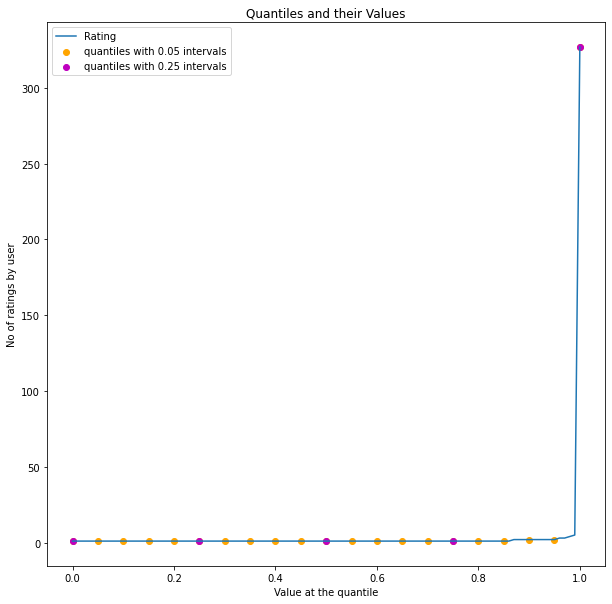

In [24]:
plt.figure(figsize=(10,10))
plt.title("Quantiles and their Values")
quantiles.plot()
# quantiles with 0.05 difference
plt.scatter(x=quantiles.index[::5], y=quantiles.values[::5], c='orange', label="quantiles with 0.05 intervals")
# quantiles with 0.25 difference
plt.scatter(x=quantiles.index[::25], y=quantiles.values[::25], c='m', label = "quantiles with 0.25 intervals")
plt.ylabel('No of ratings by user')
plt.xlabel('Value at the quantile')
plt.legend(loc='best')
plt.show()

In [25]:
print('\n No of rated product more than 50 per user : {}\n'.format(sum(no_of_rated_products_per_user >= 50)) )


 No of rated product more than 50 per user : 21



#Popularity Based Recommendation
Popularity based recommendation system works with the trend. It basically uses the items which are in trend right now. For example, if any product which is usually bought by every new user then there are chances that it may suggest that item to the user who just signed up.

The problems with popularity based recommendation system is that the personalization is not available with this method i.e. even though you know the behaviour of the user you cannot recommend items accordingly.

In [0]:
#Getting the new dataframe which contains users who has given 50 or more ratings
new_df=electronics_data.groupby("productId").filter(lambda x:x['Rating'].count() >=50)

Text(0.5, 1.0, '# RATINGS per Product')

Text(0.5, 0, 'Product')

Text(0, 0.5, 'No of ratings per product')

[]

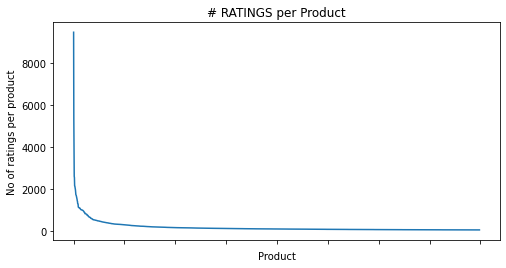

In [27]:
no_of_ratings_per_product = new_df.groupby(by='productId')['Rating'].count().sort_values(ascending=False)

fig = plt.figure(figsize=plt.figaspect(.5))
ax = plt.gca()
plt.plot(no_of_ratings_per_product.values)
plt.title('# RATINGS per Product')
plt.xlabel('Product')
plt.ylabel('No of ratings per product')
ax.set_xticklabels([])

plt.show()

In [28]:
#Average rating of the product 
new_df.groupby('productId')['Rating'].mean().head()

productId
0972683275    4.470980
1400501466    3.560000
1400501520    4.243902
1400501776    3.884892
1400532620    3.684211
Name: Rating, dtype: float64

In [31]:
new_df.groupby('productId')['Rating'].mean().sort_values(ascending=False).head()

productId
B0000DYV9H    4.947368
B000053HC5    4.945783
B00009R96C    4.885714
B00005LE76    4.879310
B0002E52S4    4.861111
Name: Rating, dtype: float64

In [34]:
#Total no of rating for product
new_df.groupby('productId')['Rating'].count().sort_values(ascending=False).head()

productId
B0002L5R78    9487
B0001FTVEK    5345
B00007E7JU    3523
B00007M1TZ    2608
B00004ZCJE    2547
Name: Rating, dtype: int64

In [0]:
ratings_mean_count = pd.DataFrame(new_df.groupby('productId')['Rating'].mean())

In [0]:
ratings_mean_count['rating_counts'] = pd.DataFrame(new_df.groupby('productId')['Rating'].count())

In [37]:
ratings_mean_count.head()

,Rating,rating_counts
productId,,
0972683275,4.470980,1051
1400501466,3.560000,250
1400501520,4.243902,82
1400501776,3.884892,139
1400532620,3.684211,171


In [38]:
ratings_mean_count['rating_counts'].max()

9487

<Figure size 576x432 with 0 Axes>

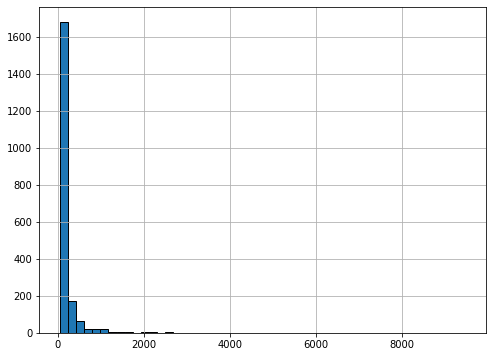

In [39]:
plt.figure(figsize=(8,6))
plt.rcParams['patch.force_edgecolor'] = True
ratings_mean_count['rating_counts'].hist(bins=50)


<Figure size 576x432 with 0 Axes>

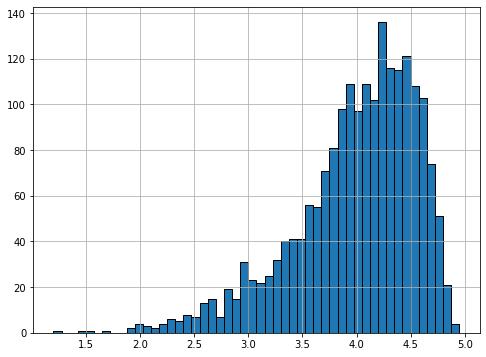

In [40]:
plt.figure(figsize=(8,6))
plt.rcParams['patch.force_edgecolor'] = True
ratings_mean_count['Rating'].hist(bins=50)

<Figure size 576x432 with 0 Axes>

<Figure size 576x432 with 0 Axes>

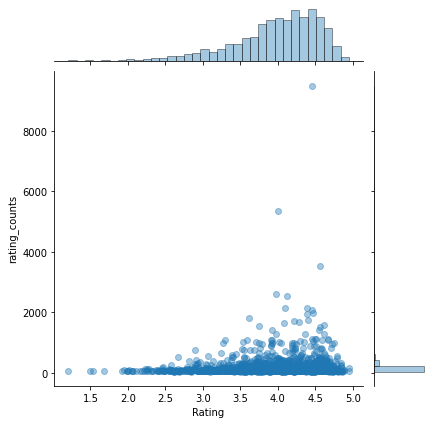

In [41]:
plt.figure(figsize=(8,6))
plt.rcParams['patch.force_edgecolor'] = True
sns.jointplot(x='Rating', y='rating_counts', data=ratings_mean_count, alpha=0.4)

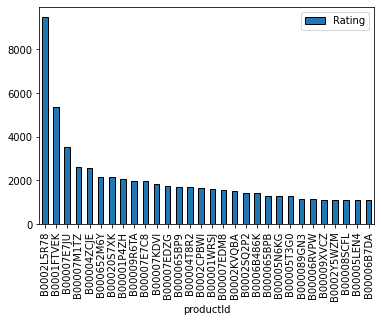

In [42]:
popular_products = pd.DataFrame(new_df.groupby('productId')['Rating'].count())
most_popular = popular_products.sort_values('Rating', ascending=False)
most_popular.head(30).plot(kind = "bar")

#**Collaborative filtering (Item-Item recommedation)**
Collaborative filtering is commonly used for recommender systems. These techniques aim to fill in the missing entries of a user-item association matrix. We are going to use collaborative filtering (CF) approach. CF is based on the idea that the best recommendations come from people who have similar tastes. In other words, it uses historical item ratings of like-minded people to predict how someone would rate an item.Collaborative filtering has two sub-categories that are generally called memory based and model-based approaches.

In [43]:
pip install surprise

In [0]:
from surprise import KNNWithMeans
from surprise import Dataset
from surprise import accuracy
from surprise import Reader
import os
from surprise.model_selection import train_test_split

In [0]:
#Reading the dataset
reader = Reader(rating_scale=(1, 5))
data = Dataset.load_from_df(new_df,reader)

In [0]:
#Splitting the dataset
trainset, testset = train_test_split(data, test_size=0.3,random_state=10)

In [49]:
# Use user_based true/false to switch between user-based or item-based collaborative filtering
algo = KNNWithMeans(k=5, sim_options={'name': 'pearson_baseline', 'user_based': False})
algo.fit(trainset)

Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.


In [0]:
# run the trained model against the testset
test_pred = algo.test(testset)

In [51]:
test_pred

[Prediction(uid='A3KWVINP3O2JU', iid='B00004ZCJE', r_ui=4.0, est=4.144063027574564, details={'actual_k': 0, 'was_impossible': False}),
 Prediction(uid='A3TD42X3DNZT7T', iid='B000075UZ7', r_ui=5.0, est=3.6021505376344085, details={'actual_k': 0, 'was_impossible': False}),
 Prediction(uid='A1ZJ3221S7DYSQ', iid='B00006HCIX', r_ui=2.0, est=4.064259962582604, details={'was_impossible': True, 'reason': 'User and/or item is unkown.'}),
 Prediction(uid='A2Z9H86XRXBVEI', iid='B0002OKCX4', r_ui=4.0, est=4.476190476190476, details={'actual_k': 0, 'was_impossible': False}),
 Prediction(uid='ADXKYE179RH23', iid='B00005N6KG', r_ui=5.0, est=4.064259962582604, details={'was_impossible': True, 'reason': 'User and/or item is unkown.'}),
 Prediction(uid='A2HAVQSKXK1Z50', iid='B0002XQDSS', r_ui=5.0, est=4.138121546961326, details={'actual_k': 0, 'was_impossible': False}),
 Prediction(uid='A3C23R5W1RJLJC', iid='B00003006E', r_ui=3.0, est=4.064259962582604, details={'was_impossible': True, 'reason': 'User a

In [54]:
# get RMSE
print("Item-based Model : Test Set")
accuracy.rmse(test_pred, verbose=True)

Item-based Model : Test Set
RMSE: 1.3393


1.3392736572376256

# Model-based collaborative filtering system
These methods are based on machine learning and data mining techniques. The goal is to train models to be able to make predictions. For example, we could use existing user-item interactions to train a model to predict the top-5 items that a user might like the most. One advantage of these methods is that they are able to recommend a larger number of items to a larger number of users, compared to other methods like memory based approach. They have large coverage, even when working with large sparse matrices.



In [55]:
new_df1=new_df.head(10000)
ratings_matrix = new_df1.pivot_table(values='Rating', index='userId', columns='productId', fill_value=0)
ratings_matrix.head()

productId,0972683275,1400501466,1400501520,1400501776,1400532620,1400532655,140053271X,1400532736,1400599997,1400698987,3744295508,6301977173,7214047977,8862935293,9573212919,9575871979,9625993428,9888002198,9966694544,9983891212,9984984354,9985511476,B000001OM4,B000001OM5,B000001OMI,B000001ON6,B00000DM9W,B00000IGBF,B00000J05A,B00000J061,B00000J08Q,B00000J0D2,B00000J0D5,B00000J0D8,B00000J1EJ,B00000J1EP,B00000J1EQ,B00000J1F3,B00000J1GA,B00000J1QK,B00000J1QR,B00000J1SC,B00000J1TX,B00000J1U8,B00000J1UQ,B00000J1V3,B00000J1V5,B00000J3NF,B00000J3Q7,B00000J3UJ,B00000J434,B00000J4EY,B00000J4FS,B00000J4GE,B00000J6WY,B00000JBAT,B00000JBHP,B00000JBPB,B00000JCT8,B00000JCTO,B00000JD34,B00000JDF5,B00000JDF6,B00000JDHV,B00000JFE3,B00000JFIF,B00000JFMK,B00000JHWX,B00000JI4F,B00000JII6,B00000JMUG,B00000JPPI,B00000JSGF,B00000JYLO,B00000JYWQ,B00000K135
userId,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
A01852072Z7B68UHLI5UG,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
A0266076X6KPZ6CCHGVS,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,5,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
A0293130VTX2ZXA70JQS,5,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
A030530627MK66BD8V4LN,4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
A0571176384K8RBNKGF8O,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,5,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


As expected, the utility matrix obtaned above is sparce, I have filled up the unknown values wth 0.



In [56]:
ratings_matrix.shape

(9832, 76)

**Transposing the matrix**

In [57]:
X = ratings_matrix.T
X.head()

userId,A01852072Z7B68UHLI5UG,A0266076X6KPZ6CCHGVS,A0293130VTX2ZXA70JQS,A030530627MK66BD8V4LN,A0571176384K8RBNKGF8O,A0590501PZ7HOWJKBGQ4,A0641581307AKT5MAOU0Q,A076219533YHEV2LJO988,A0821988FXKFYX53V4QG,A099626739FNCRNHIKBCG,A1003EYWAQFOUG,A100LLXMXDZHJZ,A10121433FMMZNY18RWZ8,A1013OEQCVS6AR,A1013Q8NLCY56R,A101DJDPGK0Q46,A101IWCCIWQWC9,A10285OSAM1MZK,A102IUFPXVDRB6,A102L0RVI4LHH3,A102RLOGIBBDMW,A102ZABPUPNYCT,A1038957GWRBP375RU5T,A103XY7DJYZHFN,A104VHQ06KFLDT,A1058D8UFZL711,A105AZN9C8UAOJ,A105TOJ6LTVMBG,A106YUCY4SVX1D,A1077JEY0CE3BB,A1079KKA0AXSL3,A107I2HYD2JZ5G,A1089S59XSJT2T,A108LYH0NZ9919,A108UXJTIV8XXY,A10956KAP9F1CO,A109ZR833WIFQS,A10BH1JDT6SNGA,A10BOETDPAFJ4C,A10CRW7XRJBJ2G,...,AZKKZ58QBXZUA,AZKOO6TVQBDAF,AZL95QPWJDM3Y,AZM8PD2KBVXN5,AZMCJ61JS6L3X,AZMY6E8B52L2T,AZN6Z0QRMZYX8,AZNMO6T8G0ZEU,AZNVF1G1GJRR4,AZO3DZAJ8S0D9,AZODG8OG0CETL,AZOFJX627J181,AZOPTWUSS6UM0,AZOTUFIYPVNDT,AZPPZOYTNLEN0,AZPT44204EODM,AZPT6K5K0IVCT,AZPYIAOEAV3OZ,AZQ2YSCWSKWX6,AZQ9DYG38GVBR,AZQJQBJ75DHMS,AZQOWHUHXMIMS,AZQQVI9RHJYH6,AZQTJ6HUS5L2Q,AZRPGTU8A7KD5,AZS8W54PXQ01W,AZSUNAT0BRQDU,AZTC7YC8PKG39,AZTC8ZV20NO1D,AZV9WA9MNT0FB,AZWOPBY75SGAM,AZX0ZDVAFMN78,AZX5LAN9JEAFF,AZX7I110AF0W2,AZXKUK895VGSM,AZXP46IB63PU8,AZYTSU42BZ7TP,AZZGJ2KMWB7R,AZZMV5VT9W7Y8,AZZST8OYL5P4Q
productId,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0972683275,0,0,5,4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,5,0,0,0,0,0,5,0,4,0,0,0,5,0,0,0,0,0,...,0,0,0,5,0,0,0,0,0,5,0,0,0,0,0,5,0,0,0,0,0,0,0,0,0,0,0,5,0,0,0,0,0,0,0,0,0,0,0,0
1400501466,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,5,5,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1400501520,0,0,0,0,0,0,0,0,0,3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1400501776,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
1400532620,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,5,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,5,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [58]:
X.shape

(76, 9832)

**Unique products in subset of data**

In [0]:
X1 = X

In [60]:
#Decomposing the Matrix
from sklearn.decomposition import TruncatedSVD
SVD = TruncatedSVD(n_components=10)
decomposed_matrix = SVD.fit_transform(X)
decomposed_matrix.shape

(76, 10)

In [61]:
#Correlation Matrix
correlation_matrix = np.corrcoef(decomposed_matrix)
correlation_matrix.shape

(76, 76)

In [68]:
X.index[74]

'B00000JYWQ'

In [70]:
i = "B00000JYWQ"
product_names = list(X.index)
product_ID = product_names.index(i)
product_ID

74

Correlation for all items with the item purchased by this customer based on items rated by other customers people who bought the same product



In [71]:
correlation_product_ID = correlation_matrix[product_ID]
correlation_product_ID.shape

(76,)

Recommending top 25 highly correlated products in sequence



In [72]:
Recommend = list(X.index[correlation_product_ID > 0.65])
# Removes the item already bought by the customer
Recommend.remove(i) 
Recommend[0:24]

['7214047977',
 '9966694544',
 '9983891212',
 '9984984354',
 '9985511476',
 'B000001OM4',
 'B000001OM5',
 'B000001ON6',
 'B00000IGBF',
 'B00000J05A',
 'B00000J08Q',
 'B00000J1EP',
 'B00000J1EQ',
 'B00000J1F3',
 'B00000J1SC',
 'B00000J1UQ',
 'B00000J3NF',
 'B00000J3UJ',
 'B00000J434',
 'B00000J4FS',
 'B00000JBAT',
 'B00000JBHP',
 'B00000JDHV',
 'B00000JFIF']

Here are the top 10 products to be displayed by the recommendation system to the above customer based on the purchase history of other customers in the website.